In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

from configs import *
from FM_match import *
import pickle

set_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate

In [2]:
img1 = '22-082_10X_WGA488_MD1-594_3-Scene-10-TA29c1-Image Export-51_s0c1x0-7537y0-9376'
img2 = '22-082_10X_WGA488_MD1-594_3-Scene-11-TA29c2-Image Export-52_s0c1x0-7534y0-7538'
list_images = [img1, img2]

FM_generate_VAE_inputs(
    list_images,
    images_dir,
    dir_save_npz
)

FM_generate_embedding(
    dir_save_npz,
    dir_embedding,
    VAE_checkpoint,
    device
)

list_label_1 = sorted([int(f.split("_roi_")[1].split(".")[0]) for f in os.listdir(dir_save_npz) if img1 in f])
list_label_2 = sorted([int(f.split("_roi_")[1].split(".")[0]) for f in os.listdir(dir_save_npz) if img2 in f])
print(f"n_ROI_img1={len(list_label_1)}, n_ROI_img2={len(list_label_2)}")

label2index = {
    "img1": {l:i for i,l in enumerate(list_label_1)},
    "img2": {l:i for i,l in enumerate(list_label_2)},
}

index2label = {
    "img1": {i:l for i,l in enumerate(list_label_1)},
    "img2": {i:l for i,l in enumerate(list_label_2)},
}

Generate 2662 npz files


100%|███████████████████████████████████████| 2662/2662 [03:20<00:00, 13.28it/s]


Generate 2898 npz files


100%|██████████████████████████████████████| 6753/6753 [00:37<00:00, 179.08it/s]

n_ROI_img1=2662, n_ROI_img2=2898


In [3]:
matched_labels = match_fibers(
    img1, list_label_1,
    img2, list_label_2,
    label2index,
    dir_embedding,
    images_dir, 
    cls_checkpoint,
    device,
    list_k = [3,5,7],

    # initial guess
    n_initial_guess = 100,
    n_pair_selected = 4,
    max_cost_geo_initial = 0.1,
    min_cls_logit_init = 0.75,

    # local prediction
    n_neighbors_ref_init = 256,
    n_neighbors_ref_min = 32,
    max_cost_geo_neighbors = 1,
    min_cls_logit = 0.25,
    patience_label = 5,    
    n_neighbors_validation = 3,
    n_processes = 60,
)

   Get classification logits and local spatial cost matrix


100%|███████████████████████████████████████| 7534/7534 [01:32<00:00, 81.03it/s]


   Making 75 initial prediction with highest scores
   Select and filter groups of 4 pairs from 75 initial guess
   Select 9 pairs passed all filters


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7765.63it/s]

   Start local prediction
   Local prediction for 9 annotated pairs



100%|██████████████████████████████████████| 231/231 [00:00<00:00, 18277.04it/s]

      Found 222 additional pairs, count_pairs_unchanged=0
   Local prediction for 231 annotated pairs



100%|██████████████████████████████████████| 662/662 [00:00<00:00, 17780.33it/s]

      Found 431 additional pairs, count_pairs_unchanged=0
   Local prediction for 662 annotated pairs



100%|████████████████████████████████████| 1123/1123 [00:00<00:00, 29499.98it/s]

      Found 461 additional pairs, count_pairs_unchanged=0
   Local prediction for 1123 annotated pairs



100%|████████████████████████████████████| 1523/1523 [00:00<00:00, 29506.38it/s]


      Found 400 additional pairs, count_pairs_unchanged=0
   Local prediction for 1523 annotated pairs


100%|████████████████████████████████████| 1762/1762 [00:00<00:00, 29211.96it/s]

      Found 239 additional pairs, count_pairs_unchanged=0
   Local prediction for 1762 annotated pairs



100%|████████████████████████████████████| 1852/1852 [00:00<00:00, 27631.80it/s]


      Found 90 additional pairs, count_pairs_unchanged=0
   Local prediction for 1852 annotated pairs


100%|████████████████████████████████████| 1937/1937 [00:00<00:00, 29801.72it/s]


      Found 85 additional pairs, count_pairs_unchanged=0
   Local prediction for 1937 annotated pairs


100%|████████████████████████████████████| 2002/2002 [00:00<00:00, 29243.56it/s]


      Found 65 additional pairs, count_pairs_unchanged=0
   Local prediction for 2002 annotated pairs


100%|████████████████████████████████████| 2045/2045 [00:00<00:00, 29611.49it/s]

      Found 43 additional pairs, count_pairs_unchanged=0
   Local prediction for 2045 annotated pairs



100%|████████████████████████████████████| 2064/2064 [00:00<00:00, 28923.24it/s]

      Found 19 additional pairs, count_pairs_unchanged=0
   Local prediction for 2064 annotated pairs



100%|████████████████████████████████████| 2091/2091 [00:00<00:00, 29309.92it/s]

      Found 27 additional pairs, count_pairs_unchanged=0
   Local prediction for 2091 annotated pairs



100%|████████████████████████████████████| 2097/2097 [00:00<00:00, 29566.94it/s]

      Found 6 additional pairs, count_pairs_unchanged=0
   Local prediction for 2097 annotated pairs



100%|████████████████████████████████████| 2090/2090 [00:00<00:00, 27492.51it/s]


      Found -7 additional pairs, count_pairs_unchanged=0


In [4]:
with open(f"{dir_save_prediction_output}/{img1}___vs___{img2}___paired.pkl", "wb") as f:
    pickle.dump(matched_labels, f)

In [9]:
# load classifier
classifier = PairClassifier().to(device)
classifier.load_state_dict(torch.load(cls_checkpoint))
classifier.eval()

scores, spatial_dist, neighbors_dicts, cp_outputs = GetCostMatrix(
    img1, list_label_1,
    img2, list_label_2,
    classifier,
    dir_embedding,
    images_dir, 
    list_k=[3,5,7],
)

100%|███████████████████████████████████████| 7534/7534 [01:35<00:00, 78.93it/s]


In [17]:
labels1_unannot = [l for l in list_label_1 if l not in [i[0] for i in matched_labels]]
labels2_unannot = [l for l in list_label_2 if l not in [i[1] for i in matched_labels]]

idx1_unannot = [label2index['img1'][l] for l in labels1_unannot]
idx2_unannot = [label2index['img2'][l] for l in labels2_unannot]

print(f"   {len(labels1_unannot)}/{len(labels2_unannot)} ROIs yet unannotated.") 

   572/808 ROIs yet unannotated.


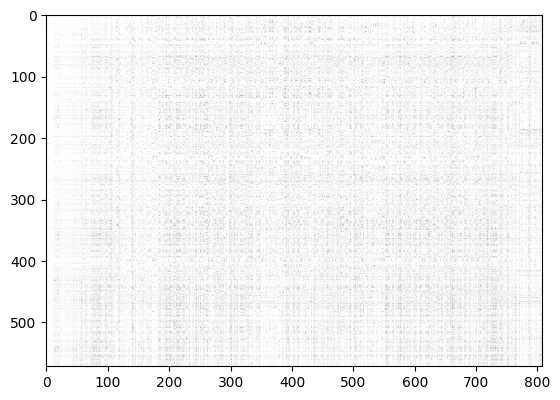

In [21]:
M = (scores*spatial_dist)[np.ix_(idx1_unannot, idx2_unannot)]
plt.imshow(M, cmap="gray_r")

# Save and evaluate the output

In [5]:
path_img1 = f"{images_dir}/{img1}.png"
path_img2 = f"{images_dir}/{img2}.png"

cp_output1 = segment_image(path_img1)
cp_output2 = segment_image(path_img2)

labels1_filtered = filter_ROIs(cp_output1, size_crop)
labels2_filtered = filter_ROIs(cp_output2, size_crop)

o1 = [cp_output1, labels1_filtered]
o2 = [cp_output2, labels2_filtered]

In [6]:
# o1, o2 = plot_FM_prediction(
#     f"{images_dir}/{img1}.png",
#     f"{images_dir}/{img2}.png",
#     matched_labels,
#     dpi=100,
# )

In [7]:
save_FM_prediction(
    img1,
    images_dir,
    0, #0/1: 1st/2nd image in the pair
    o1,
    matched_labels,
    dir_save_prediction_output,
    dpi=80,
)

save_FM_prediction(
    img2,
    images_dir,
    1, #0/1: 1st/2nd image in the pair
    o2,
    matched_labels,
    dir_save_prediction_output,
    dpi=80,
)

100%|███████████████████████████████████████| 2898/2898 [32:40<00:00,  1.48it/s]


In [8]:
# os.system(f"rm {dir_embedding}/*")
# os.system(f"rm {dir_save_npz}/*")